In [16]:
import matplotlib
matplotlib.use('Agg')
import tensorflow as tf
import matplotlib.pyplot as plt
from sargan_dep.sargan_models import SARGAN
import os
from tqdm import tqdm
from random import shuffle
import skimage.measure as ski_me
import time
import numpy as np
import torch
from sargan_dep.cifar_helper import get_data, chunks
from sargan_dep.sar_utilities import add_gaussian_noise
from sargan_dep.alert_utilities import send_images_via_email

from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import torch
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from scipy.ndimage.filters import gaussian_filter
from PIL import Image

In [7]:
img_size = (224,224,1)
trained_model_path = 'trained_models/sargan_mnist_gaussian_corrupted'
BATCH_SIZE = 64
NOISE_STD_RANGE = [0.0, 0.4]

In [36]:
data_root='sar_data/MNIST'
NUM_ITERATION = 85
BATCH_SIZE = 64
GPU_ID = 1
MAX_EPOCH = 55
LEARNING_RATE = 0.001
NOISE_STD_RANGE = [0.0, 0.4]
mnist = datasets.MNIST(root=data_root, train=True, transform=torchvision.transforms.ToTensor(), target_transform=None, download=True).data.float()
data_transform = Compose([ToTensor()])
    
train_loader = DataLoader(datasets.MNIST(root=data_root, train=True, transform=data_transform, target_transform=None, download=True),
                              batch_size=BATCH_SIZE, shuffle=True)
    
    
val_loader = DataLoader(datasets.MNIST(root=data_root, train=False, transform=data_transform, target_transform=None, download=True),
                            batch_size=BATCH_SIZE, shuffle=False)

In [37]:
trainiter = iter(train_loader)
features, labels = next(trainiter)
features = features.data.numpy().transpose(0,2,3,1)

In [21]:
features_copy = features.copy()/2
corrupted_batch = np.array([add_gaussian_noise(image, sd=np.random.uniform(NOISE_STD_RANGE[0], NOISE_STD_RANGE[1])) for image in features_copy])
corrupted_batch[0]=gaussian_filter(corrupted_batch[0], sigma=1)
transform2=Resize([224,224])
image=torch.from_numpy(corrupted_batch[0])
print(image.shape)
outbatch2=np.array(transform2(image))
print(outbatch2.shape)

from PIL import Image
Image.fromarray((corrupted_batch[0,:,:,0])*255).show()


torch.Size([28, 28, 1])
(28, 224, 224)


In [9]:
batch2=np.load('original_images.NPY')







img_size = (224,224,1)
trained_model_path = 'trained_models/sargan_mnist_gaussian_corrupted'
BATCH_SIZE = 64
NOISE_STD_RANGE = [0.1, .9]
    
#sargan model
#reshaping the images to a square
newbatch2=batch.reshape([len(batch2),28,28])
#upping the size of the image
transform2=Compose([ Resize((224, 224)), Normalize((np.mean(batch2)), (np.std(batch2),))])
#creating the original batch
transformed_batch2=np.array(transform(torch.from_numpy(newbatch2))).reshape([len(batch2),224,224,1])

FileNotFoundError: [Errno 2] No such file or directory: 'original_images.NPY'

In [7]:
testbatch=outbatch
testbatch=testbatch.reshape([len(testbatch),28,28])
#upping the size of the image
transform=Resize([224,224])
#creating the original batch
testbatch=np.array(transform(torch.from_numpy(testbatch))).reshape([len(batch),224,224,1])
Image.fromarray(transformed_batch2[0,:,:,0]*255).show()
#Image.fromarray(corruptedbatch[0,:,:,0]*255).show()
Image.fromarray(transformed_batch[0,:,:,0]*255).show()

NameError: name 'outbatch' is not defined

In [4]:
#downgrading the transform
outbatch2=outbatch
#ncbatch=corruptedbatch
print(type(outbatch2))
#Image.fromarray(ncbatch[0,:,:,0]*255).show()
#Image.fromarray(outbatch2[0]*255).show()
transform2=Resize([28,28])
Image.fromarray(outbatch2[0]*255).show()
outbatch2=np.array(transform2(torch.from_numpy(outbatch2)))
outbatch2=outbatch2.reshape([len(batch),784])

<class 'numpy.ndarray'>


In [29]:
print(print(carray[1]))

[1.       1.       1.       1.       1.       1.       1.       1.
 1.       0.996875 0.996875 0.99375  0.98125  0.98125  0.98125  0.953125
 0.9375   0.940625 0.928125 0.903125 0.90625  0.86875  0.825    0.825
 0.8      0.80625  0.765625 0.715625 0.671875 0.71875  0.65     0.59375
 0.546875 0.5375   0.471875 0.403125 0.378125 0.29375  0.340625 0.278125
 0.271875 0.221875 0.215625 0.171875 0.15     0.1125   0.134375 0.1
 0.109375 0.06875  0.0625   0.05     0.05     0.025    0.025    0.034375
 0.01875  0.       0.0125   0.0125   0.01875  0.00625  0.003125 0.003125
 0.       0.003125 0.003125 0.       0.003125 0.003125 0.       0.003125
 0.       0.       0.       0.003125 0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.003125 0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.  

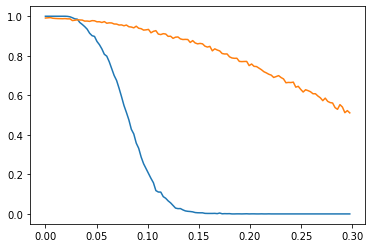

In [2]:
import numpy as np
import matplotlib.pyplot as plt

carray=np.load('loop_data/mnist/mnist_loop_list_corr0.npy')
barray=np.load('loop_data/mnist/mnist_loop_list0.npy')
carray=np.zeros([len(carray),len(carray[0])])
barray=carray.copy()
listnum=45
for i in range(listnum):
    carray+=np.load('loop_data/mnist/mnist_loop_list_corr'+str(i)+'.npy')
    barray+=np.load('loop_data/mnist/mnist_loop_list'+str(i)+'.npy')
carray=carray/listnum
barray=barray/listnum
fig, ax = plt.subplots()

ax.plot(carray[0],carray[1])
ax.plot(carray[0],barray[1])

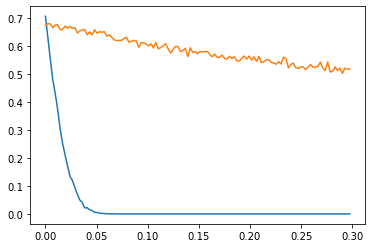

In [4]:
import numpy as np
import matplotlib.pyplot as plt

carray=np.load('loop_data/fmnist/fmnist_loop_list_corr0.npy')
barray=np.load('loop_data/fmnist/fmnist_loop_list0.npy')
carray=np.zeros([len(carray),len(carray[0])])
barray=carray.copy()
listnum=45
for i in range(listnum):
    carray+=np.load('loop_data/fmnist/fmnist_loop_list_corr'+str(i)+'.npy')
    barray+=np.load('loop_data/fmnist/fmnist_loop_list'+str(i)+'.npy')
carray=carray/listnum
barray=barray/listnum
fig, ax = plt.subplots()
ax.plot(carray[0],carray[1])
ax.plot(carray[0],barray[1])

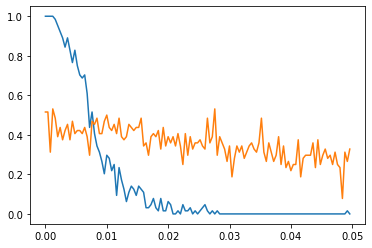

In [4]:
import numpy as np
import matplotlib.pyplot as plt

carray=np.load('loop_data/cifar10/cifar10_loop_list_corr0.npy')
barray=np.load('loop_data/cifar10/cifar10_loop_list0.npy')
carray=np.zeros([len(carray),len(carray[0])])
barray=carray.copy()
listnum=1
for i in range(listnum):
    carray+=np.load('loop_data/cifar10/cifar10_loop_list_corr'+str(i)+'.npy')
    barray+=np.load('loop_data/cifar10/cifar10_loop_list'+str(i)+'.npy')
carray=carray/listnum
barray=barray/listnum
fig, ax = plt.subplots()
ax.plot(carray[0],carray[1])
ax.plot(carray[0],barray[1])